# Machine Learning project CS-433: NMR spectroscopy supervised learning



___

## Schedules:

* Week 10 (18-24 November): 
 * Tests of various linear models/simple NN on a 10% subset of data
* Week 11 (25-1 December):
 * Feature selection: being able to come with a good set of features
* Week 12 (2-8 December):
 * Start of big scale analysis with Spark, implementation of the models which perform well at small scale
* Week 13 (9-15 December):
 * Wrapping up
* Week 14 (16-22 December): 
 * 19th December: Deadline

___

## Table of contents

1. [Log Book](#log)
2. [Pipeline](#pipeline)
3. [Data Processing](#data_proc) <br>
&emsp;3.1. [Data Vizualisation](#data_viz) <br>
&emsp;3.2 [Outliers detection](#outliers) <br>
  &emsp;&emsp;3.2.1 [DBSCAN](#dbscan) <br>
  &emsp;&emsp;3.2.2 [Inter quantile range method](#iqr) <br>
&emsp;3.3 [Scaling](#scaling) <br>
&emsp;&emsp;3.3.1 [Min max scaling](#minmax) <br>
&emsp;3.4 [Dimensionality reduction](#dim_red) <br>
  &emsp;&emsp;3.4.1 [PCA](#pca) <br>
&emsp;3.5 [Feature Selection](#feat_sel) <br>
  &emsp;&emsp;3.5.1 [Relative importance from linear regression](#rel_imp_lin) <br>
  &emsp;&emsp;3.5.2 [Random forest](#rand_for) <br>
  &emsp;&emsp;3.5.3 [Univariate feature selection](#un_feat_sel) <br>
  &emsp;&emsp;3.5.4 [Recursive feature selection](#rec_feat_sel) <br>
  &emsp;&emsp;3.5.5 [Lasso Regression](#lasso) <br>
  &emsp;&emsp;3.5.6 [Boruta](#boruta) <br>
&emsp;3.6 [Models](#models) <br>
  &emsp;&emsp;3.6.1 [Linear Models](#lin_mods) <br>
  &emsp;&emsp;3.6.2 [Neural Networks](#NN) <br>
4. [Main](#main) <br>
   4.1 [ANN implementation](#ann_imp) <br>
    

In [20]:
import os
import scipy.stats
import sklearn.metrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet

# For neural net part
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.join(sys.path[0],'src'))
import helpers as hl
import data_viz as dv
import outliers as out
import lin_mods as lm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Import data
<a id='import'></a>

In [3]:
data_folder = './data'

files = os.listdir(data_folder)  
X_files = [filename for filename in files if (filename.endswith('.npy') and ('rsr' in filename))]
y_files = [filename for filename in files if (filename.endswith('.npy') and ('chemical_shielding' in filename))]


tot_data_X = np.load(data_folder + '/' + X_files[1], mmap_mode='r')
tot_data_Y = np.load(data_folder + '/' + y_files[0], mmap_mode='r')
data_X,data_y = hl.load_data(100,tot_data_X,tot_data_Y)

In [38]:
print(X_tot.shape)
print(y_tot.shape)

(38514, 14400)
(38514,)


In [39]:
RUN = False

## 1. Data Vizualisation
<a id='data_viz'></a>

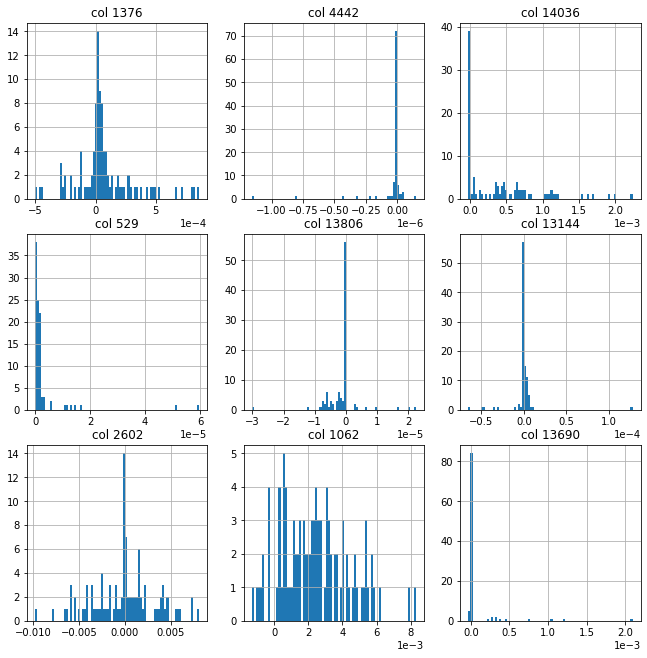

In [41]:
dv.plot_distribs(pd.DataFrame(data_X))

We see that the different features are scaled pretty differently, we might want to scale them beforehand. Since they don' look like following a gaussian, we'll apply min/max scaling: but in order to do so, we first need to get rid of the outliers thanks to one of the following methods
* Zscore: not adapted as our data might not be gaussian
* DBScan:
* Isolation Forest:

## 2. Data preprocessing
<a id='preprocess'></a>

### 2.1 Outliers detection
<a id='outliers'></a>

#### 2.1.1 DBSCAN
<a id = 'dbscan'></a>

Problem: computationally too demanding.

#### 2.2.2 Interquartile range method (IQR)
<a id = 'iqr'></a>

Consists in considering as outliers all data points that lie in >1.5 interquartile range from the quartiles:

* Method 1: removing the samples which are considered as outliers in their label
* Method 2: removing the samples which are considered as outliers for any of the x features

In [53]:
data_X,data_y = hl.load_data(100,tot_data_X,tot_data_Y)
lin = LinearRegression()
SCORING = ['neg_mean_squared_error', 'neg_mean_absolute_error','r2']

#TODO:: make an accurate KFold

#method 1
out_remover = out.IQR_outlier()
out_remover.fit(data_X)
data_X1,data_y1 = out_remover.transform(data_X,data_y)
scores1 = cross_validate(lin, data_X1, data_y1, cv=10,scoring = SCORING)

#method 2
data_X2,data_y2 = out.IQR_y_outliers(data_X,data_y)
scores2 = cross_validate(lin,data_X,data_y,cv = 10,scoring = SCORING)

We compare the 2 methods on a classic linear regression task in order to assess which one performs better:

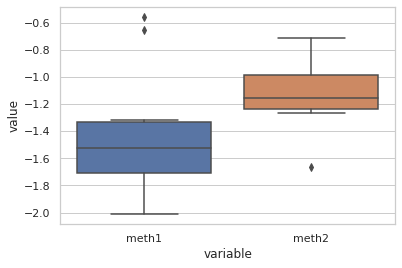

In [54]:
def plot_box_plot(scores1,scores2,metric):
    sns.set(style="whitegrid")
    scores_df = pd.DataFrame({'meth1':scores1[metric],'meth2':scores2[metric]})
    sns.boxplot(x="variable", y="value", data=pd.melt(scores_df))
plot_box_plot(scores1,scores2,'test_neg_mean_absolute_error')

*c.f.* `data_preprocessing.py`

## 2.2 Scaling

#### 2.2.1 Min/max Scaling
<a id='minmax'></a>

Minmax scaling seems as an appropriate way to scale our data only if an outlier removing method is applied beforehand.

In [55]:
# TODO: plot of min/max scaled data

#### 2.2.2 Data Normalization
<a id='minmax'></a>

In [55]:
# TODO: plot of normalized data

#### 2.2.3 Standardization
<a id='std'></a>

As our data definitely does not follow a normal distribution, standardization has not been taken into account for this dataset.

## 2.3 Dimension Reduction

#### 1.4 PCA
<a id='pca'></a>

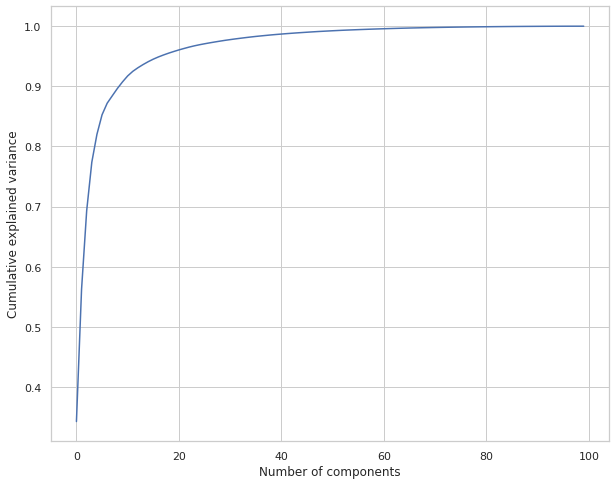

In [59]:
data_X,data_y = hl.load_data(100,tot_data_X,tot_data_Y)
hl.plot_PCA(100,data_X)

## 2.4 Feature Selection
<a id='feat_sel'></a>

#### 3.5.3 Univariate feature selection
<a id='un_feat_sel'></a>

Running univariate feature selection on the laptops turned out to be extremely costly: this is why we performed it after running a PCA on the trained subset of data. This was before having access to more computational power.

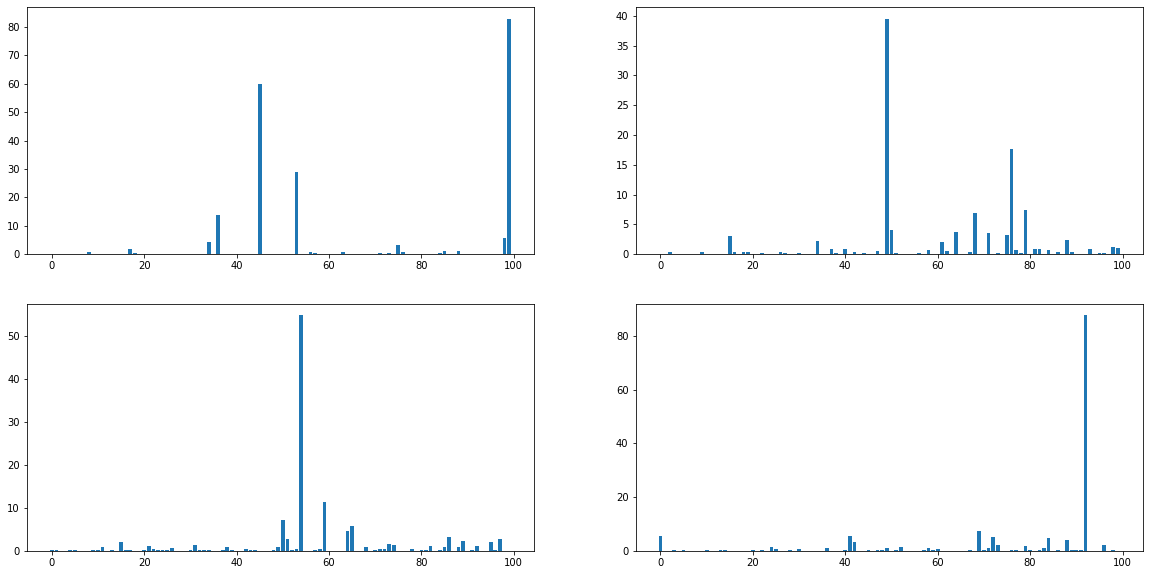

In [7]:
fig,axes = plt.subplots(2,2,figsize = (20,10))
for i in range(4):
    data_X,data_y = hl.load_data(100,tot_data_X,tot_data_Y)
    pca = PCA(n_components = 100)
    pca.fit(data_X)
    data_X_pca = pca.transform(data_X)
    hl.univ_feat_sel(data_X_pca,data_y,ax = axes[np.unravel_index(i,(2,2))])

As we can see, the importance of the various PCs is not regular across various random samples for data_X: this is probably due to the fact that the PCs are not the same for a different subset of data. 

#### 3.5.4 Recursive feature elimination
<a id='rec_feat_sel'></a>

RFS turns out to be extensively demanding in computational power: it crashed many times on our laptops.

In [79]:
#almost impossible without a pca ==> pca first
data_X,data_y = hl.load_data(60,tot_data_X,tot_data_Y)
pca = PCA(n_components = 3)
pca.fit(data_X)
data_X_pca = pca.transform(data_X)
ridge = Ridge(alpha = 0.1)
rfe = RFE(ridge,0.1)
fit = rfe.fit(data_X,data_y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)


Num Features: 3
Selected Features: [False False False ... False False False]
Feature Ranking: [   94 13683 13650 ...  7192  6586  5788]


## 2.5 Linear Models Optimization
<a id='models'></a>

### 2.5.1 Ridge Regression

In [33]:
data_X,data_y = hl.load_data(100,tot_data_X,tot_data_Y)

iqr = out.IQR_outlier()
min_max = MinMaxScaler()
pca = PCA(n_components=3)
data_X,data_y = iqr.fit_transform(data_X,data_y)
pipeline = Pipeline([('min_max', min_max), ('pca', pca)])
data_X = pipeline.fit_transform(data_X)

interv = np.logspace(np.log10(0.001),np.log10(10000),)

398.1071705534969


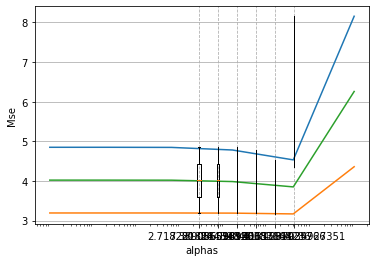

In [80]:
alph_opt = lm.test_alphas_meth(Ridge,interv,data_X,data_y,k = 2)
print(alph_opt)

### 2.5.2 Lasso Regression

In [ ]:
data_X,data_y = hl.load_data(100,tot_data_X,tot_data_Y)

iqr = out.IQR_outlier()
min_max = MinMaxScaler()
pca = PCA(n_components=3)
data_X,data_y = iqr.fit_transform(data_X,data_y)
pipeline = Pipeline([('min_max', min_max), ('pca', pca)])
data_X = pipeline.fit_transform(data_X)

interv = np.logspace(np.log10(0.001),np.log10(10000),6)

### 2.5.2 Elastic Nets

## 2. PyTorch NN
<a id='pytorch'></a>

_c.f._ `neural_nets.py` file.

## 3. Keras NN
<a id='keras'></a>

_c.f._ `k_models.py` file.

## 4. Main
<a id='main'></a>

The main consists of the different grid search for linear models and trainings for NN.

In [ ]:
# Load data prior feeding it to the mode
def load_process_data(n, iqr=False, pca=False, scale=False):
    # load all datas
    # filter (iqr)
    if iqr:
        # remove outliers
    # select n samples and split in train-test sets
    # perform pca
    if pca:
        # do pca
    # normalize 
    if scale:
        # do normalization
    #return X_train, X_test, y_train, y_test
    raise NotImplementedError 

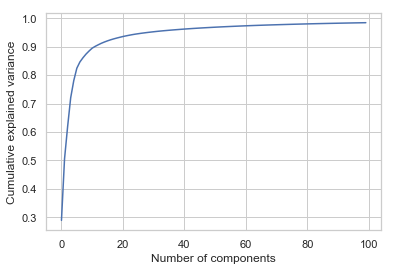

In [123]:
# How man PCA components do we need?
plot_PCA(100, X_filtered)

>40 components to explain 95% of the total variance.

#### 4.1 PyTorch pipeline
<a id='main_pytorch'></a>

In [ ]:
def load_process_data(n, iqr=False, pca=False, scale=False):
    if iqr:
        X_train, X_test, y_train, y_test = load_data_train_test(n, X_tot, y_tot, iqr=apply_iqr)
    else:
        X_train, X_test, y_train, y_test = load_data_train_test(n, X_tot, y_tot)
        
    if scale:
        min_max = MinMaxScaler()
        X_train, X_test = apply_scaler(min_max, X_train, X_test)
        
    if pca:
        n = 80
        X_train, X_test = do_PCA(X_train, X_test, n)
        nb_input_neurons = n

    return X_train, X_test, y_train, y_test


##### 4-fold cross-validation

In [143]:
from sklearn.model_selection import KFold

mse_storage = []
mae_storage = []
r2_storage = []

mini_batch_size = 10
nb_input_neurons = 14400

# Load data, remove outliers but do not split yet into train and test
X, y = load_data(38514, tot_data_x=X_tot, tot_data_y=y_tot, iqr=True)

print(X.shape)
print(y.shape)

(37338, 14400)
(37338,)


In [147]:
kf = KFold(n_splits=4, shuffle=True)

for idx, (train_index, test_index) in enumerate(kf.split(X)):
    print("FOLD {}".format(idx+1))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_input = torch.Tensor(X_train)
    test_input = torch.Tensor(X_test)
    train_target = torch.Tensor(y_train.reshape(len(y_train), 1))
    test_target = torch.Tensor(y_test.reshape(len(y_test), 1))
    
    model = Net_4(nb_input_neurons) 
    losses = train_model(model, train_input, train_target, mini_batch_size, monitor_loss=True)

    #Make predictions
    y_hat = compute_pred(model, test_input)
    #Compute score
    mse_nn, mae_nn, r2_nn = compute_score(y_test, y_hat.detach().numpy())
    
    mse_storage.append(mse_nn)
    mae_storage.append(mae_nn)
    r2_storage.append(r2_nn)

FOLD 1
[epoch 1] loss: 195956.91
[epoch 2] loss: 5717.32
[epoch 3] loss: 3410.36
[epoch 4] loss: 2653.15
[epoch 5] loss: 2306.10
[epoch 6] loss: 2093.14
[epoch 7] loss: 1942.76
[epoch 8] loss: 1829.11
[epoch 9] loss: 1739.60
[epoch 10] loss: 1666.88
[epoch 11] loss: 1606.23
[epoch 12] loss: 1554.56
[epoch 13] loss: 1509.86
[epoch 14] loss: 1470.77
[epoch 15] loss: 1436.31
[epoch 16] loss: 1405.71
[epoch 17] loss: 1378.39
[epoch 18] loss: 1353.86
[epoch 19] loss: 1331.73
[epoch 20] loss: 1311.67
[epoch 21] loss: 1293.40
[epoch 22] loss: 1276.70
[epoch 23] loss: 1261.37
[epoch 24] loss: 1247.26
[epoch 25] loss: 1234.22
[epoch 26] loss: 1222.14
[epoch 27] loss: 1210.92
[epoch 28] loss: 1200.46
[epoch 29] loss: 1190.69
[epoch 30] loss: 1181.55
[epoch 31] loss: 1172.98
[epoch 32] loss: 1164.92
[epoch 33] loss: 1157.34
[epoch 34] loss: 1150.19
[epoch 35] loss: 1143.43
[epoch 36] loss: 1137.03
[epoch 37] loss: 1130.97
[epoch 38] loss: 1125.22
[epoch 39] loss: 1119.75
[epoch 40] loss: 1114.55


In [148]:
with open('metrics_all_dataset2_net4_4fold.pkl', 'wb') as f:
    pickle.dump([mse_storage, mae_storage, r2_storage], f)

In [149]:
print('MSE: {:0.2f} +/- {:0.4f} \nMAE: {:0.2f} +/- {:0.4f} \nR2: {:0.2f} +/- {:0.4f}'.format(np.mean(mse_storage), np.std(mse_storage), np.mean(mae_storage), np.std(mae_storage), np.mean(r2_storage), np.std(r2_storage)))

MSE: 0.42 +/- 0.0220 
MAE: 0.48 +/- 0.0126 
R2: 0.95 +/- 0.0019


#### 4.2 Keras pipeline
<a id='main_keras'></a>

In [15]:
models = [k_models.model_5, k_models.model_6, k_models.model_7]

model_names = [] #[m.__name__ for m in models]
epochs_list = []
mse_list = []
mae_list = []

X_train, X_test, y_train, y_test = load_data_train_test(2000, X_tot, y_tot)

nb_epochs = [100]
for m in models:
    for e in nb_epochs:
        network = m(X_train, 'mean_absolute_error')
        network.fit(X_train, y_train, epochs=e, batch_size=10, validation_split=0.2)

        y_hat = network.predict(X_test)
        mse_nn, mae_nn = compute_score(y_test, y_hat)

        model_names.append(m.__name__)
        epochs_list.append(e)
        mse_list.append(mse_nn)
        mae_list.append(mae_nn)


Train on 1280 samples, validate on 320 samples
Epoch 1/100
1280/1280 [==============================] - 2s 2ms/step - loss: 20.5533 - mean_absolute_error: 20.5534 - val_loss: 10.6779 - val_mean_absolute_error: 10.6779
Epoch 2/100
1280/1280 [==============================] - 2s 2ms/step - loss: 3.4412 - mean_absolute_error: 3.4412 - val_loss: 2.1116 - val_mean_absolute_error: 2.1116
Epoch 3/100
1280/1280 [==============================] - 2s 2ms/step - loss: 1.8856 - mean_absolute_error: 1.8856 - val_loss: 1.7832 - val_mean_absolute_error: 1.7832
Epoch 4/100
1280/1280 [==============================] - 2s 2ms/step - loss: 1.6338 - mean_absolute_error: 1.6338 - val_loss: 1.6364 - val_mean_absolute_error: 1.6364
Epoch 5/100
1280/1280 [==============================] - 2s 2ms/step - loss: 1.4684 - mean_absolute_error: 1.4684 - val_loss: 1.4507 - val_mean_absolute_error: 1.4507
Epoch 6/100
1280/1280 [==============================] - 2s 2ms/step - loss: 1.3487 - mean_absolute_error: 1.3487 

In [16]:
print(tabulate([model_names, ['Epochs']+epochs_list, ['MSE']+mse_list, ['MAE']+mae_list], headers="firstrow", tablefmt='fancy_grid'))

╒════════╤════════════╤════════════╤════════════╕
│        │    model_5 │    model_6 │    model_7 │
╞════════╪════════════╪════════════╪════════════╡
│ Epochs │ 100        │ 100        │ 100        │
├────────┼────────────┼────────────┼────────────┤
│ MSE    │   1.01402  │   0.944624 │   1.2443   │
├────────┼────────────┼────────────┼────────────┤
│ MAE    │   0.768377 │   0.754768 │   0.866663 │
╘════════╧════════════╧════════════╧════════════╛


In [291]:
# Quick tests
apply_pca = False
apply_iqr = True

if apply_iqr:
    X_train, X_test, y_train, y_test = load_data_train_test(12000, X_tot, y_tot, iqr=apply_iqr)
else:
    X_train, X_test, y_train, y_test = load_data_train_test(12000, X_tot, y_tot)

if apply_pca:
    n = 100
    X_train, X_test = do_PCA(X_train, X_test, n)
    nb_input_neurons = n


In [338]:
k_ann = k_models.model_8(X_train, 'mean_absolute_error') 
k_ann.fit(X_train, y_train, epochs=150, batch_size=10, validation_split=0.2)

Train on 7680 samples, validate on 1920 samples
Epoch 1/150
7680/7680 [==============================] - 27s 3ms/step - loss: 4.3517 - val_loss: 1.1326
Epoch 2/150
7680/7680 [==============================] - 23s 3ms/step - loss: 1.0146 - val_loss: 0.8708
Epoch 3/150
7680/7680 [==============================] - 23s 3ms/step - loss: 0.8197 - val_loss: 0.7872
Epoch 4/150
7680/7680 [==============================] - 21s 3ms/step - loss: 0.7380 - val_loss: 0.7370
Epoch 5/150
7680/7680 [==============================] - 22s 3ms/step - loss: 0.6953 - val_loss: 0.6850
Epoch 6/150
7680/7680 [==============================] - 28s 4ms/step - loss: 0.6662 - val_loss: 0.6687
Epoch 7/150
7680/7680 [==============================] - 23s 3ms/step - loss: 0.6464 - val_loss: 0.6513
Epoch 8/150
7680/7680 [==============================] - 22s 3ms/step - loss: 0.6306 - val_loss: 0.6370
Epoch 9/150
7680/7680 [==============================] - 22s 3ms/step - loss: 0.6140 - val_loss: 0.6369
Epoch 10/150
768

In [339]:
# test model
y_hat = k_ann.predict(X_test)

# compute score
mse_nn, mae_nn, _ = compute_score(y_test, y_hat)
print('MSE: {:.2f} \nMAE: {:.2f}'.format(mse_nn, mae_nn))

MSE: 0.58 
MAE: 0.57


In [340]:
with open('y_hat_12000_dataset2_model8.pkl', 'wb') as f:
    pickle.dump(y_hat, f)

**Results tracking**

Model    | MSE  | MAE  | PCA | IQR |    n     | dataset | *n* PCs | Epochs | Scaling | 
---      | ---  | ---  | --- | --- |   ---    |   ---   |   ---   |   ---  |   ---   |
model_6  | 0.93 | 0.70 | Yes | Yes |  20000   |   2     |   40    |   150  |   No    |
model_6  | 0.85 | 0.67 | No  | Yes |   4000   |   2     |    -    |   150  |   No    |
model_6  | 0.78 | 0.64 | Yes | Yes |  20000   |   2     |   60    |   150  |   No    | 
model_6  | 0.75 | 0.63 | Yes | Yes |  25000   |   2     |   70    |   200  |   No    |
model_6  | 0.67 | 0.60 | No  | Yes |   8000   |   2     |    -    |   150  |   No    |
model_6  | 0.75 | 0.62 | Yes | Yes |  25000   |   2     |  100    |   150  |   No    |
model_6  | 0.60 | 0.55 | No  | Yes |  12000   |   2     |    -    |   150  |   No    |
Net_3    | 1.01 | 0.74 | Yes | Yes |   5000   |   2     |   80    |   100  |   No    |
Net_3    | 1.03 | 0.73 | Yes | Yes |   8000   |   2     |   80    |   150  |   No    |
Net_3    | 0.65 | 0.60 | No  | Yes |   8000   |   2     |    -    |   150  |   No    |
Net_3    | 0.52 | 0.54 | No  | Yes |  12000   |   2     |    -    |   150  |   No    |
model_8  | 0.58 | 0.57 | No  | Yes |  12000   |   2     |    -    |   150  |   No    |
Net_3    | 0.57 | 0.56 | No  | Yes |  12000   |   3     |    -    |   150  |   No    |
Net_3    | 0.65 | 0.62 | No  | Yes |  12000   |   2     |    -    |   150  |   Yes   |
Net_3    | 1.00 | 0.76 | Yes | Yes |  12000   |   2     |   80    |   150  |   Yes   |
Net_3    | 0.86 | 0.69 | Yes | Yes |  25000   |   2     |   80    |   150  |   Yes   |
Net_4    | 0.47 | 0.52 | No  | Yes |  12000   |   2     |   -     |   150  |   Yes   |
Net_5    | 0.54 | 0.54 | No  | Yes |  12000   |   2     |   -     |   150  |   Yes   |

Note: 
- Larger increase in performances when using more PCs (say 60).
- Obviously computationally less demanding
- Will the increase in number of samples without PCA perform better? YES it does.
- Loss evolution indicates that 150 epochs are not necessary (try with 120)
- Plateau reached using larger number of PCs
- $r^2 = 0.95$ for Net_4

## 5. Stats
<a id='stats'></a>

#### 5.1 IQR vs. sample number
<a id='iqr_vs_n'></a>

Note: I should do a function but j'ai la flemme.

In [19]:
# To save time: always apply PCA for now
apply_pca = True
apply_iqr = [False, True]
n_samples = [5000, 20000] #[5000, 20000]
n_iter = 4 #5

noiqr_5000 = []
noiqr_20000 = []
iqr_5000 = []
iqr_20000 = []

for b in apply_iqr:
    for n in n_samples:
        for i in range(n_iter):
            # load each time a different set (kind of cross-val)
            X_train, X_test, y_train, y_test = load_data_train_test(n, X_tot, y_tot, iqr=b)
            
            # PCA
            if apply_pca:
                n_pcs = 80
                X_train, X_test = do_PCA(X_train, X_test, n_pcs)
                #nb_input_neurons = n
            
            # NN
            k_ann = k_models.model_6(X_train, 'mean_absolute_error') 
            k_ann.fit(X_train, y_train, epochs=150, batch_size=10, validation_split=0.2)
            
            y_hat = k_ann.predict(X_test)
            mse_nn, mae_nn = compute_score(y_test, y_hat)
            
            # Store result
            # Case: iqr, 5000 samples
            if (b and (n == n_samples[0])):
                iqr_5000.append(mse_nn)
            elif ((not b) and (n == n_samples[0])):
                noiqr_5000.append(mse_nn)
            elif (b and (n == n_samples[1])):
                iqr_20000.append(mse_nn)
            else:
                noiqr_20000.append(mse_nn)

Train on 3200 samples, validate on 800 samples
Epoch 1/150
3200/3200 [==============================] - 1s 287us/step - loss: 20.0163 - val_loss: 7.9898
Epoch 2/150
3200/3200 [==============================] - 1s 174us/step - loss: 2.1726 - val_loss: 1.1877
Epoch 3/150
3200/3200 [==============================] - 1s 176us/step - loss: 1.0646 - val_loss: 0.9910
Epoch 4/150
3200/3200 [==============================] - 1s 176us/step - loss: 0.9258 - val_loss: 0.8876
Epoch 5/150
3200/3200 [==============================] - 1s 174us/step - loss: 0.8713 - val_loss: 0.8659
Epoch 6/150
3200/3200 [==============================] - 1s 172us/step - loss: 0.8536 - val_loss: 0.8499
Epoch 7/150
3200/3200 [==============================] - 1s 175us/step - loss: 0.8411 - val_loss: 0.8589
Epoch 8/150
3200/3200 [==============================] - 1s 173us/step - loss: 0.8331 - val_loss: 0.8565
Epoch 9/150
3200/3200 [==============================] - 1s 176us/step - loss: 0.8326 - val_loss: 0.8517
Epoch 1

In [20]:
with open('stats_iqr_vs_n_2.pkl', 'wb') as f:
    pickle.dump([noiqr_5000, noiqr_20000, iqr_5000, iqr_20000], f)

## 6. Figures
<a id='figures'></a>

#### 6.1 Distributions
<a id='fig_dist'></a>

[(-5, 65), Text(0.5, 0, 'Shielding')]

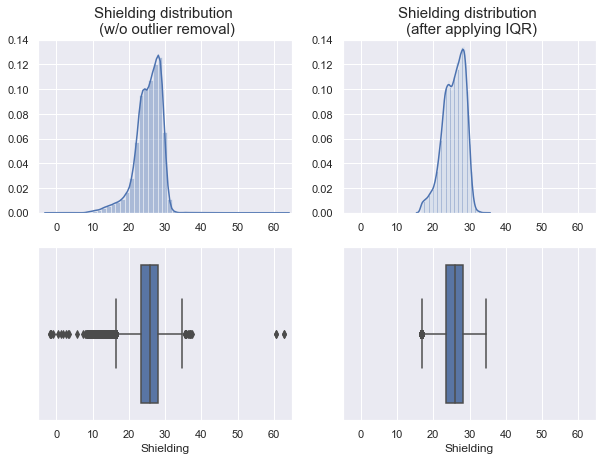

In [222]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1) 
plt.subplot(2,2,1)
plt.title('Shielding distribution \n (w/o outlier removal)', fontsize=15)
sns.distplot(y_tot).set(xlim=(-5,65),ylim=(0,0.14))
plt.subplot(2,2,2)
plt.title('Shielding distribution \n (after applying IQR)', fontsize=15)
sns.distplot(y_filtered).set(xlim=(-5,65),ylim=(0,0.14))
plt.subplot(2,2,3)
b1 = sns.boxplot(x=y_tot, linewidth=1.5).set(xlabel='Shielding', xlim=(-5,65))
#b1.set_xlabel("Shielding",fontsize=10)
plt.subplot(2,2,4)
sns.boxplot(x=y_filtered, linewidth=1.5).set(xlabel='Shielding', xlim=(-5,65))

In [223]:
fig.savefig("iqr.png")

#### 6.2 IQR
<a id='fig_iqr'></a>

In [21]:
df_iqr = pd.DataFrame({
    'noiqr_5000': noiqr_5000,
    'noiqr_20000': noiqr_20000,
    'iqr_5000': iqr_5000,
    'iqr_20000': iqr_20000
})
df_iqr

,noiqr_5000,noiqr_20000,iqr_5000,iqr_20000
0,1.966410,1.164088,0.891626,0.832680
1,1.286497,1.257255,0.887988,0.744232
2,1.757331,0.852787,1.002124,0.833200
3,1.238798,1.663109,1.009964,0.722377


In [63]:
tot_iqr_n = noiqr_5000 + noiqr_20000 + iqr_5000 + iqr_20000

iqrs_labels = ['no','no','no','no','no','no','no','no','yes','yes','yes','yes','yes','yes','yes','yes']
n_labels = [5000,5000,5000,5000,20000,20000,20000,20000,5000,5000,5000,5000,20000,20000,20000,20000]

my_df = pd.DataFrame({
    'mse': tot_iqr_n,
    'iqr': iqrs_labels,
    'n': n_labels
})
my_df

,mse,iqr,n
0,1.966410,no,5000
1,1.286497,no,5000
2,1.757331,no,5000
3,1.238798,no,5000
4,1.164088,no,20000
5,1.257255,no,20000
6,0.852787,no,20000
7,1.663109,no,20000
8,0.891626,yes,5000
9,0.887988,yes,5000


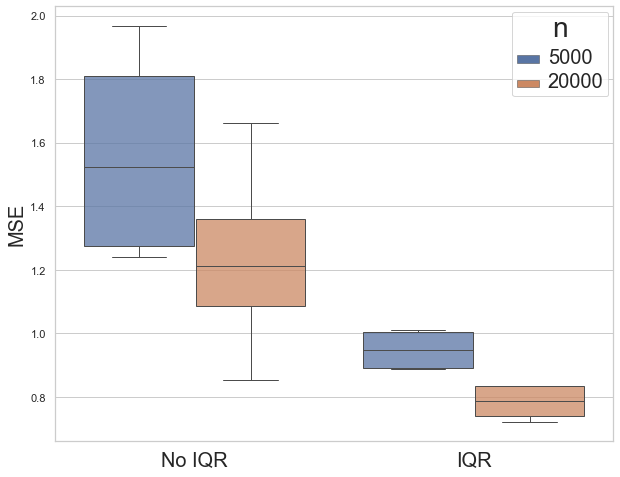

In [86]:
iqr_vs_n, _ = plt.subplots(figsize=(10,8))
sns.set(style="whitegrid")

ax = sns.boxplot(data=my_df, x='iqr', y='mse', hue='n', linewidth=1.)
ax.set_xticklabels(['No IQR', 'IQR'], fontsize=20)
ax.set_xlabel('', fontsize=20)
ax.set_ylabel('MSE', fontsize=20)

plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='28')

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .75))

In [82]:
iqr_vs_n.savefig("iqr_vs_n_2.png")

#### 6.3 Feature distributions
<a id='fig_feature_dist'></a>

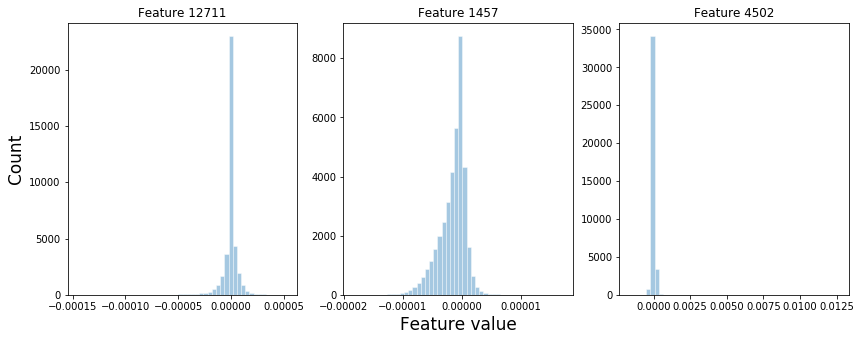

In [18]:
feature_number = [12711, 1457, 4502]

feature_0 = X_tot[:, feature_number[0]]
feature_1 = X_tot[:, feature_number[1]]
feature_2 = X_tot[:, feature_number[2]]


fig = plt.figure(figsize=(14,5))

# Divide the figure into a 2x1 grid, and give me the first section
ax_1 = fig.add_subplot(131)

# Divide the figure into a 2x1 grid, and give me the second section
ax_2 = fig.add_subplot(132)
ax_3 = fig.add_subplot(133)


sns.distplot(feature_0, ax=ax_1, kde=False, hist_kws=dict(edgecolor="w", linewidth=1))

ax_1.axes.set_title("Feature {}".format(str(feature_number[0]), fontsize=20))
ax_1.set_xlabel("", fontsize=17)
ax_1.set_ylabel("Count",fontsize=17)

sns.distplot(feature_1, ax=ax_2, kde=False, hist_kws=dict(edgecolor="w", linewidth=1))

ax_2.axes.set_title("Feature {}".format(str(feature_number[1]), fontsize=20))
ax_2.set_xlabel("Feature value", fontsize=17)
ax_2.set_ylabel("", fontsize=17)
                    
sns.distplot(feature_2, ax=ax_3, kde=False, hist_kws=dict(edgecolor="w", linewidth=1))

ax_3.axes.set_title("Feature {}".format(str(feature_number[2]), fontsize=20))
ax_3.set_xlabel("", fontsize=17)
ax_3.set_ylabel("", fontsize=17)

fig.subplots_adjust(hspace=0.3)

>Note NN
- Simple model is the best (1 hidden of 100 neurons)
- For now dropout does not help
- Increasing the number of hidden neurons to 200 does not help
- Decreasing the number of hidden neurons to 50 shows problem of cenvergence
- Increasing the number of samples show little or no improvements (filter with **IQR** and **minmaxscaler** before and/or **PCA**)
- Test Dropout in PyTorch (specify when training and when NOT training)!
- Again even with batch norm, the simplest model with one hidden seems the best
- Keras: Adam better for model 3 with 100 neurons in hidden layer (sinon does not converge with SGD). Can also try with opt='adam' (...)
- **OK definitely best with 100 hidden neurons and adam as optimizer**
- Now check with PCA, min_max scaling
- Increasing the number of epochs seems a good idea
- IQR helps (ouf)!
- Increasing the number of samples helps also (ouf)!
- Not sure if PCA useful with Keras models
- Model_6 still the best at this point. Try with DEEP net (lots of 'small' layers)?

> About PCA
- Shall we normalize before?
- How does the PCA method from sklearn work? Normalize before?
- When trying without PCA > apply a SCALER